In [141]:
# !pip install umap-learn

In [142]:
# !pip install hdbscan

In [143]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy import sparse
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import warnings

warnings.filterwarnings('ignore')
# from sklearn.cluster import KMeans
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ml-2025-spring-unsupervised/sample_submission.csv
/kaggle/input/ml-2025-spring-unsupervised/train.npz


In [144]:
train = sparse.load_npz("/kaggle/input/ml-2025-spring-unsupervised/train.npz")

In [145]:
train = pd.DataFrame(train.toarray())

In [146]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,3039,3040,3041,3042,3043,3044,3045,3046,3047,3048
0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,-2.768933,...,-0.701483,0.0,0.0,0.0,0.0,0.0,0.0,9.159356,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,-3.888860,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,4.432927,0.0,0.0
2,0.0,0.000000,1.0,0.0,0.0,0.421439,0.0,0.0,0.0,-4.933763,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,6.108399,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,-1.206711,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2.201683,0.0,0.0
4,0.0,0.984401,0.0,0.0,0.0,0.358189,0.0,0.0,0.0,-2.759784,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,9.807939,0.0,0.0


In [147]:
train.shape

(21000, 3049)

In [148]:
train.duplicated().sum()

0

In [149]:
null_columns = list(train.columns[train.eq(0).all()])
print(f'{len(null_columns) / len(train) * 100:.0f}% колонок - одни нули')

3% колонок - одни нули


**Удалим их**

In [150]:
train.drop(columns=null_columns, inplace=True)
train.shape

(21000, 2433)

In [151]:
train.columns

Index([   0,    1,    2,    5,    8,    9,   10,   11,   12,   13,
       ...
       3032, 3033, 3034, 3035, 3037, 3038, 3039, 3041, 3044, 3046],
      dtype='int64', length=2433)

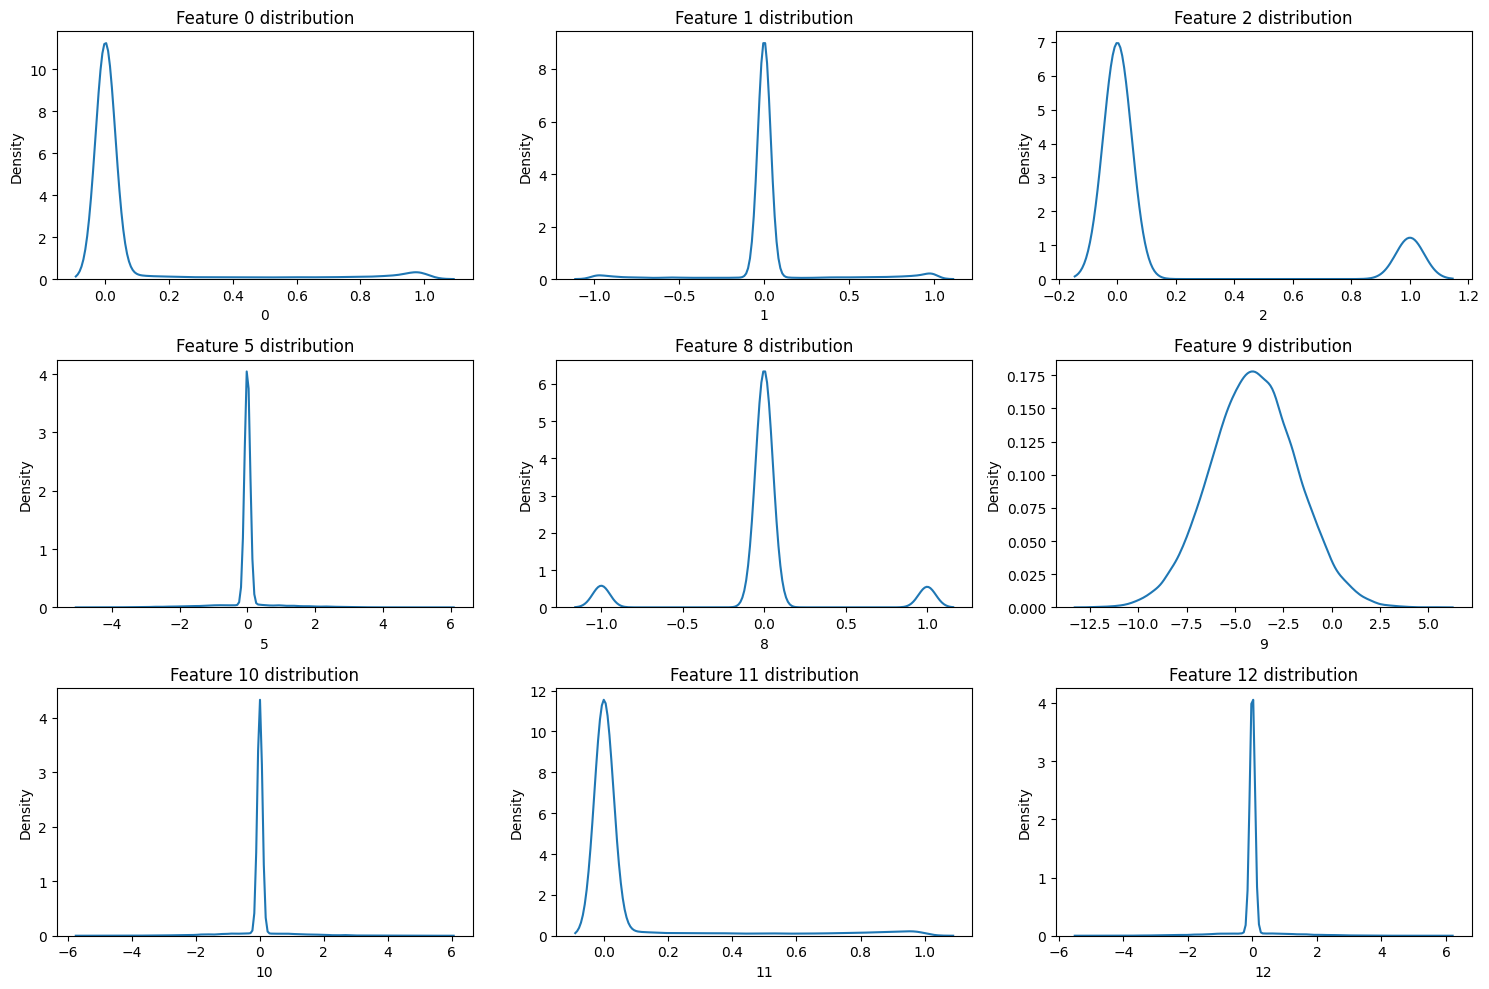

In [152]:
fig, ax = plt.subplots(3, 3, figsize=(15,10))
ax = ax.flatten()
for i, column in enumerate(train.columns[:9]):
    sns.kdeplot(train, x=column, ax=ax[i])
    ax[i].set_title(f'Feature {column} distribution')

plt.tight_layout()
plt.show()

**Из видов распределений можно прикинуть, что количество кластеров равно 3, потому что распределения мультимодальные, с числом пиков от 1 до 3, причем один пик сильно доминирует**

**Нормализуем данные**

In [153]:
scaler = StandardScaler()
train = pd.DataFrame(scaler.fit_transform(train))
train.head()

,0,1,2,3,4,5,6,7,8,9,...,2423,2424,2425,2426,2427,2428,2429,2430,2431,2432
0,-0.324334,-0.056379,-0.418278,0.000328,0.009796,0.559181,0.011472,-0.341055,0.002621,-0.421965,...,0.006433,0.006390,-0.000064,-0.017845,-1.279653,0.513747,-1.227020,0.288225,0.002317,1.555924
1,-0.324334,-0.056379,-0.418278,0.000328,0.009796,0.056887,0.011472,-0.341055,0.002621,-0.421965,...,0.006433,3.771012,-0.000064,-0.017845,0.377935,0.291121,-0.012126,0.288225,0.002317,0.125051
2,-0.324334,-0.056379,2.390753,0.701836,0.009796,-0.411757,0.011472,-0.341055,0.002621,-0.421965,...,0.006433,0.006390,-0.000064,-0.017845,0.082665,-3.381410,-0.012126,0.288225,0.002317,0.632282
3,-0.324334,-0.056379,-0.418278,0.000328,0.009796,1.259845,0.011472,-0.341055,0.002621,-0.421965,...,0.006433,0.006390,-0.000064,-0.017845,2.459979,0.291121,-0.012126,0.288225,0.002317,-0.550433
4,-0.324334,3.536633,-0.418278,0.596553,0.009796,0.563284,0.011472,-0.341055,0.002621,-0.421965,...,0.006433,2.132960,-0.000064,1.253671,0.544993,0.291121,-0.012126,0.288225,0.002317,1.752276


In [154]:
train.describe()

,0,1,2,3,4,5,6,7,8,9,...,2423,2424,2425,2426,2427,2428,2429,2430,2431,2432
count,2.100000e+04,2.100000e+04,2.100000e+04,2.100000e+04,2.100000e+04,2.100000e+04,2.100000e+04,2.100000e+04,2.100000e+04,2.100000e+04,...,2.100000e+04,2.100000e+04,2.100000e+04,2.100000e+04,2.100000e+04,2.100000e+04,2.100000e+04,2.100000e+04,2.100000e+04,2.100000e+04
mean,-1.042129e-16,9.067879e-17,6.767074e-17,-1.759439e-17,3.383537e-17,-8.882123e-15,1.015061e-17,3.437673e-16,1.082732e-17,-4.195586e-17,...,8.289665e-18,2.063957e-17,1.421085e-17,-2.106252e-17,-3.373217e-15,3.664709e-15,-2.706829e-18,3.314513e-15,-3.789561e-17,9.697217e-15
std,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,...,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00
min,-3.243336e-01,-3.706328e+00,-4.182782e-01,-8.018858e+00,-2.561726e+00,-3.743501e+00,-9.580709e+00,-3.410550e-01,-9.054991e+00,-4.219651e-01,...,-7.714129e+00,-8.006227e+00,-1.202534e+01,-3.645424e+00,-3.791156e+00,-3.381410e+00,-7.836039e+00,-3.307598e+00,-8.458633e+00,-4.531921e+00
25%,-3.243336e-01,-5.637916e-02,-4.182782e-01,3.277458e-04,9.796274e-03,-6.720464e-01,1.147216e-02,-3.410550e-01,2.620612e-03,-4.219651e-01,...,6.432551e-03,6.389925e-03,-6.431300e-05,-1.784523e-02,-6.744711e-01,2.911212e-01,-1.212585e-02,2.882246e-01,2.317032e-03,-6.748553e-01
50%,-3.243336e-01,-5.637916e-02,-4.182782e-01,3.277458e-04,9.796274e-03,3.690482e-04,1.147216e-02,-3.410550e-01,2.620612e-03,-4.219651e-01,...,6.432551e-03,6.389925e-03,-6.431300e-05,-1.784523e-02,-3.677685e-05,2.911212e-01,-1.212585e-02,2.882246e-01,2.317032e-03,-7.481721e-03
75%,-3.243336e-01,-5.637916e-02,-4.182782e-01,3.277458e-04,9.796274e-03,6.686730e-01,1.147216e-02,-3.410550e-01,2.620612e-03,-4.219651e-01,...,6.432551e-03,6.389925e-03,-6.431300e-05,-1.784523e-02,6.732865e-01,2.911212e-01,-1.212585e-02,2.882246e-01,2.317032e-03,6.801548e-01
max,4.106121e+00,3.593570e+00,2.390753e+00,9.729639e+00,2.581318e+00,4.195069e+00,1.013445e+01,4.253170e+00,1.026834e+01,2.369864e+00,...,9.002797e+00,1.001062e+01,8.828551e+00,3.609736e+00,3.936721e+00,7.783662e-01,8.395614e+00,1.234803e+00,9.173019e+00,4.222688e+00


**Сократим признаки при помощи PCA**

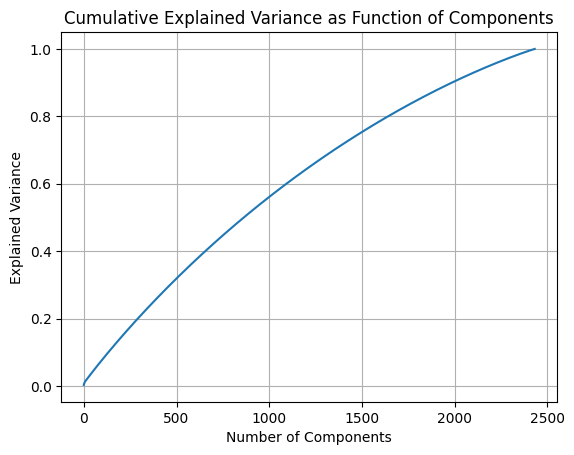

In [155]:
N_COMPONENTS = 2433
pca = PCA(n_components = N_COMPONENTS).fit(train)
varience = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(len(varience)), varience)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Cumulative Explained Variance as Function of Components')
plt.grid()
plt.show()

**По этому графику видно, что для того, чтобы получить даже 60% доли обьясненной диперсии придеться оставить более 1000 признаков.**

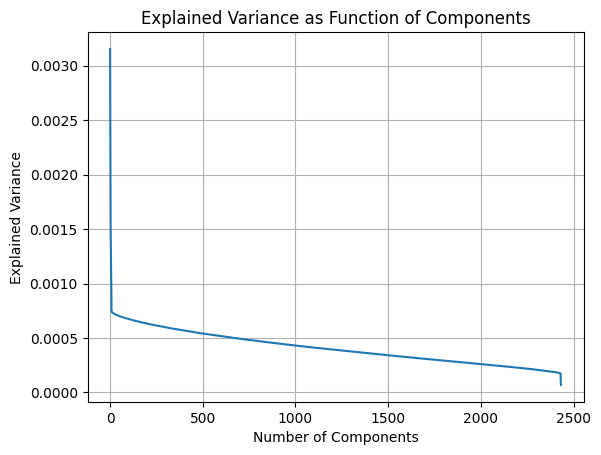

In [156]:
plt.plot(range(len(varience)), pca.explained_variance_ratio_)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance as Function of Components')
plt.grid()
plt.show()

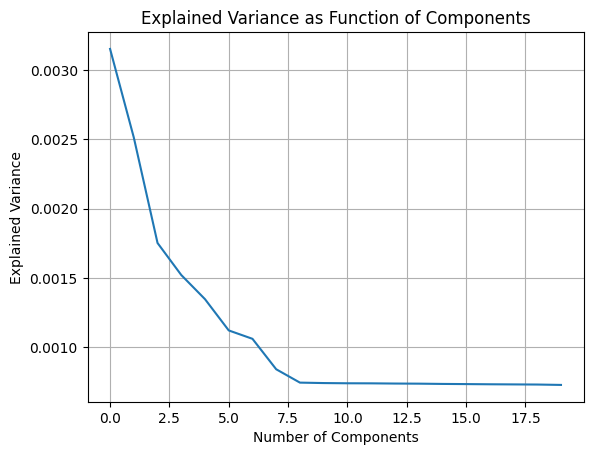

In [157]:
plt.plot(range(20), pca.explained_variance_ratio_[:20])
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance as Function of Components')
plt.grid()
plt.show()

**Но на графике отдельных дисперсий видно, что первые 9 признаков несут больше всего информативности.**

**PCA до 9 признаков**

In [158]:
train= PCA(n_components=9).fit_transform(train)

In [159]:
train = pd.DataFrame(train, columns=range(len(train[0])))

**Как изменились распределения признаков?**

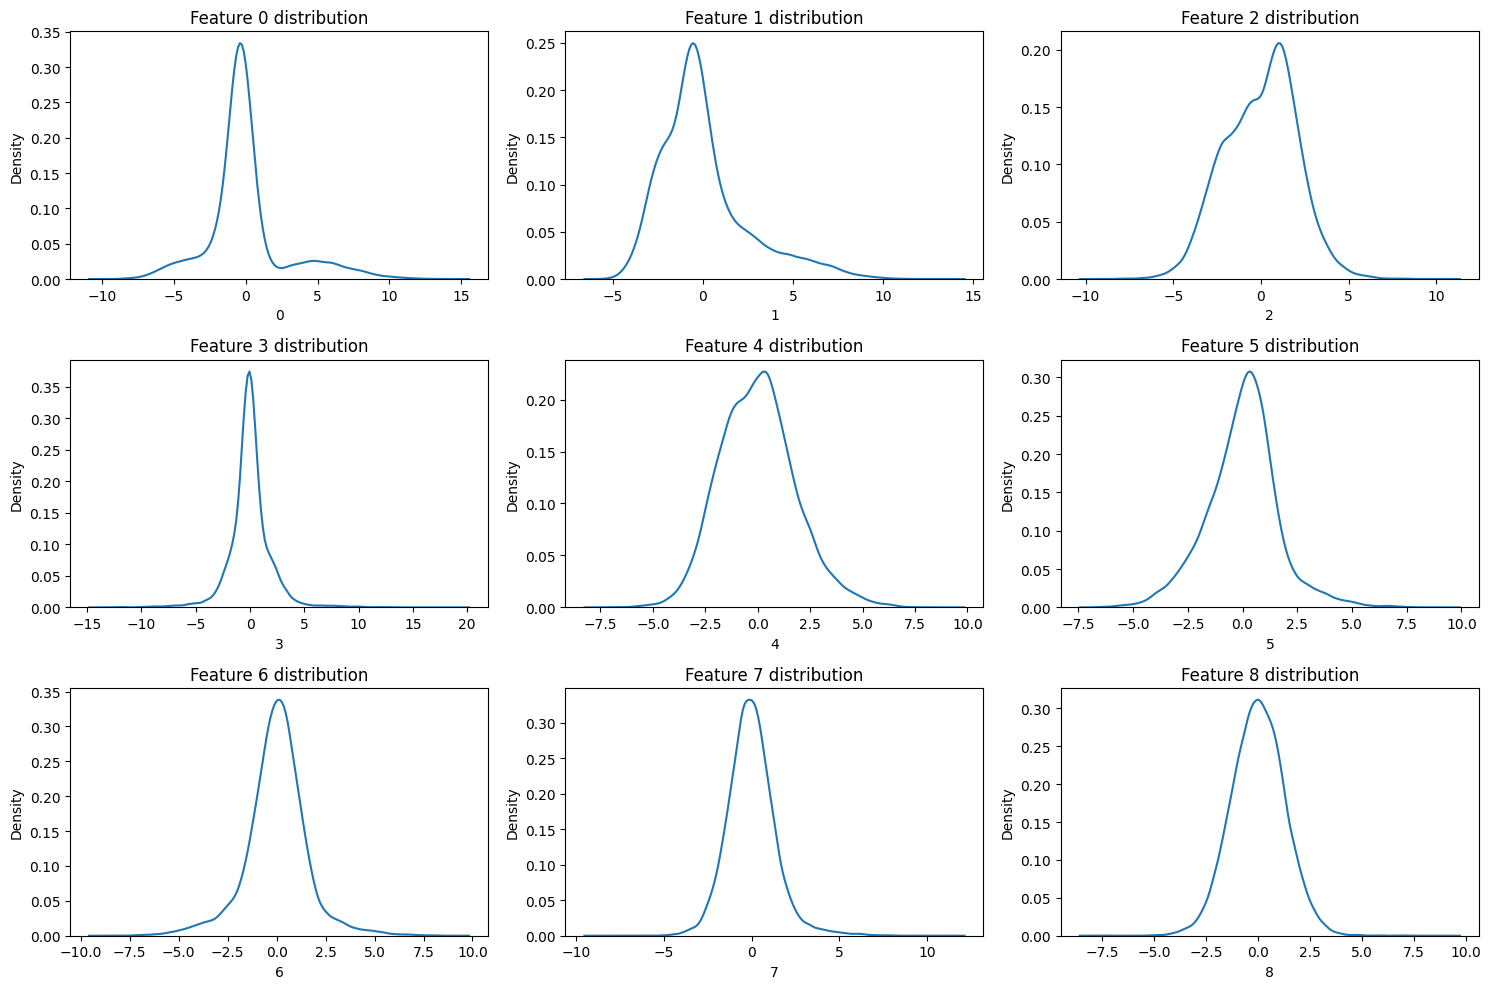

In [160]:
fig, ax = plt.subplots(3, 3, figsize=(15,10))
ax = ax.flatten()
for i, column in enumerate(train.columns[:9]):
    sns.kdeplot(train, x=column, ax=ax[i])
    ax[i].set_title(f'Feature {column} distribution')

plt.tight_layout()
plt.show()

# KMeans

**Применим метод локтя**

100%|██████████| 28/28 [00:17<00:00,  1.60it/s]


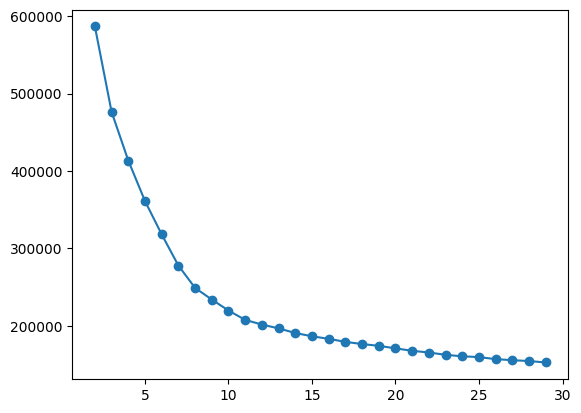

In [161]:
N_CLUSTERS = 30  
loss = []

for n in tqdm(range(2, N_CLUSTERS)):
    kmeans = KMeans(n_clusters=n, random_state=42).fit(train)
    loss.append(kmeans.inertia_)

plt.plot(range(2, N_CLUSTERS), loss, marker='o')
plt.show() 

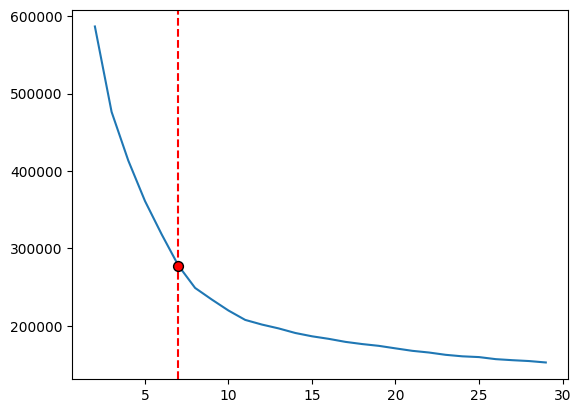

In [162]:
x_vals = list(range(2, N_CLUSTERS))
y_vals = loss

intersection_x = 7
intersection_y = loss[intersection_x - 2]  

plt.plot(x_vals, y_vals)
plt.axvline(x=intersection_x, color='r', linestyle='--')
plt.scatter([intersection_x], [intersection_y], color='red', s=50, edgecolors='black', zorder=10)
plt.show()

**Быстрое падение скора прекращается примерно на 7 кластерах**

In [163]:
kmeans = KMeans(n_clusters=7)
kmeans.fit(train)
print(f'Silhouette score : {silhouette_score(train, kmeans.labels_)}') 

Silhouette score : 0.27157332114609484


# Ансамбль GaussianMixture

**Применим метод локтя для встроенной метрики BIC score**

In [164]:
def get_best_k(train, maxn=15, n_seeds=10):
    bic_scores = []
    for n in tqdm(range(2, maxn)):
        bic_scores_n = []
        for seed in range(n_seeds):
            gmm = GaussianMixture(n_components=n, n_init=3, random_state = seed)
            gmm.fit(train)
            bic_score = gmm.bic(train)
            bic_scores_n.append(bic_score)
        bic_scores.append(bic_scores_n)

    return bic_scores

bic_scores = get_best_k(train)

100%|██████████| 13/13 [07:05<00:00, 32.76s/it]


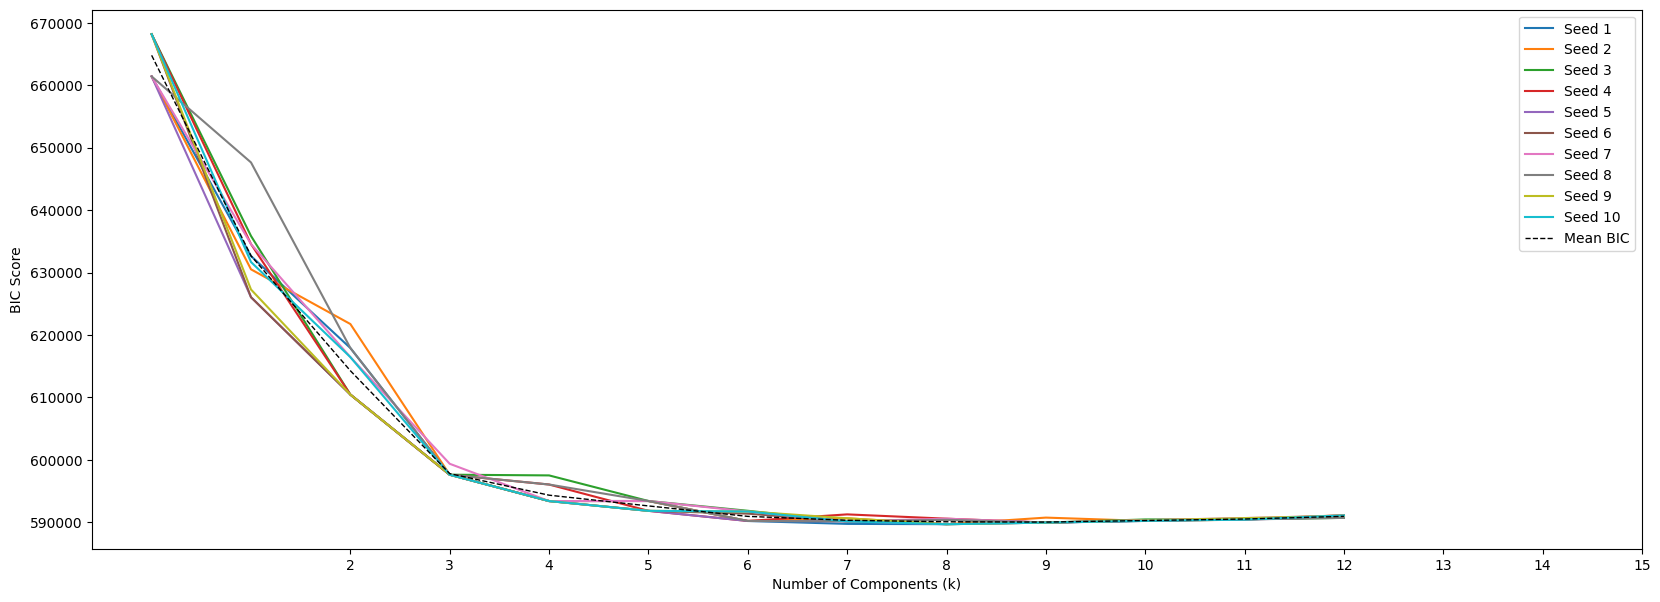

In [165]:
bic_df = pd.DataFrame(bic_scores, columns=[f'Seed_{i}' for i in range(1, 11)])

f, ax = plt.subplots(figsize=(20, 7))

for i in range(10):  
    sns.lineplot(x=bic_df.index, y=bic_df.iloc[:, i].values, ax=ax, label=f'Seed {i+1}')
    
mean_bic = bic_df.mean(axis=1)
sns.lineplot(x=bic_df.index, y=mean_bic, ax=ax, label='Mean BIC', color='black', linewidth=1, linestyle='--')

ax.set_xticks(range(2, 16))
ax.set_xlabel('Number of Components (k)')
ax.set_ylabel('BIC Score')
plt.legend()
plt.show()

**В 3 явно наблюдается локоть**

**Обучим несколько GaussianMixture и усредним вероятности, причем чтобы бороться с разными метками кластеров, будем сравнивать новые центроиды с начальными**

In [166]:
def vote(n_estimators, n_clusters, sample_size):
    count_not_unique = 0
    proba_df = pd.DataFrame(np.zeros((len(train), n_clusters)), columns=range(n_clusters))

    for i in range(n_estimators):
        train_sample = train.sample(sample_size)
        gmm = GaussianMixture(n_components=n_clusters, n_init=3, random_state=i).fit(train_sample)
        preds = gmm.predict_proba(train)

        if i == 0:
            initial_centers = gmm.means_
        
        new_classes = []
        for new_means in gmm.means_:
            distances = [np.linalg.norm(mean1 - new_means) for mean1 in initial_centers]
            new_class = np.argmin(distances)
            new_classes.append(new_class)

        if len(new_classes) != len(set(new_classes)):
            print('Not unique')
            count_not_unique += 1
            continue

        pred_probs = pd.DataFrame(preds)
        pred_probs = pred_probs.iloc[:, new_classes]
        pred_probs.columns = range(n_clusters)

        proba_df += pred_probs
        print(f'Silhouette score : {silhouette_score(train, pred_probs.idxmax(axis=1))}')
        
    predicted_probabilities = proba_df / (n_estimators - count_not_unique)
    return predicted_probabilities

In [167]:
preds = vote(50, 3, int(len(train)))

Silhouette score : 0.19332257813059825
Silhouette score : 0.3433325509527645
Silhouette score : 0.3433325509527645
Silhouette score : 0.19332257813059825
Silhouette score : 0.2714475901270421
Not unique
Silhouette score : 0.21239972196407664
Silhouette score : 0.3433325509527645
Silhouette score : 0.18203865323246152
Silhouette score : 0.2121946687736292
Silhouette score : 0.3433325509527645
Silhouette score : 0.2714475901270421
Silhouette score : 0.2125186619388183
Not unique
Silhouette score : 0.18203865323246152
Silhouette score : 0.19332257813059825
Silhouette score : 0.18203865323246152
Silhouette score : 0.21239972196407664
Silhouette score : 0.3433325509527645
Silhouette score : 0.24844820270795573
Silhouette score : 0.15292045460526824
Silhouette score : 0.24844820270795573
Not unique
Silhouette score : 0.2714475901270421
Silhouette score : 0.3433325509527645
Silhouette score : 0.3433325509527645
Not unique
Silhouette score : 0.18203865323246152
Silhouette score : 0.34333255095

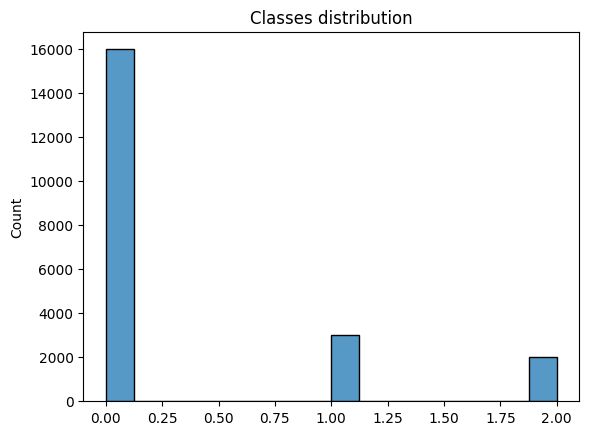

In [171]:
sns.histplot(np.argmax(preds, axis=1))
plt.title('Classes distribution')
plt.show()

**Как видно, один из классов действительно доминирует**

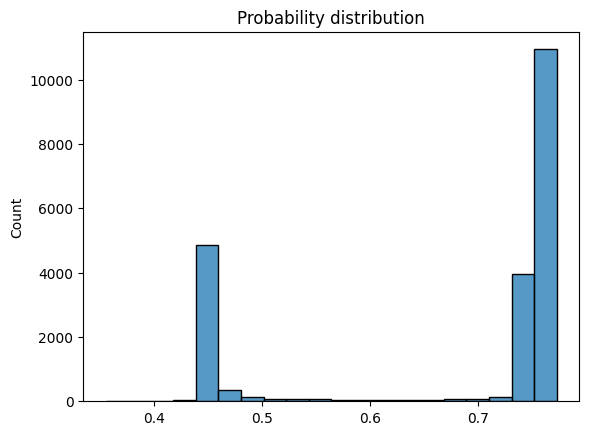

In [172]:
sns.histplot(np.sort(np.max(preds, axis=1)))
plt.title('Probability distribution')
plt.show()

In [170]:
submission = pd.DataFrame({
    'ID' : range(len(train)),
    'TARGET' : preds.idxmax(axis=1)
})
submission.to_csv('submission.csv', index=False)